In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open("../datasets/train_text.txt", "r", encoding="utf-8") as f:
    train_lines = f.readlines()
with open("../datasets/train_labels.txt", "r", encoding="utf-8") as f:
    train_labels = f.readlines()

with open("../datasets/val_text.txt", "r", encoding="utf-8") as f:
    val_lines = f.readlines()
with open("../datasets/val_labels.txt", "r", encoding="utf-8") as f:
    val_labels = f.readlines()

with open("../datasets/test_text.txt", "r", encoding="utf-8") as f:
    test_lines = f.readlines()
with open("../datasets/test_labels.txt", "r", encoding="utf-8") as f:
    test_labels = f.readlines()

In [3]:
# Create dataframes
train_df = pd.DataFrame({'text': train_lines, 'type': 'train','label': train_labels})
val_df = pd.DataFrame({'text': val_lines, 'type': 'val', 'label': val_labels})
test_df = pd.DataFrame({'text': test_lines, 'type': 'test', 'label': test_labels})

In [4]:
with open("../downloaded_datasets/comments.txt", "r", encoding="utf-8") as f:
    new_lines = [next(f) for _ in range(15000)]

downloaded_df = pd.DataFrame({'text': new_lines, 'type': 'downloaded', 'label':'unlabeled'})

In [5]:
# Combine dataframes
df = pd.concat([train_df, val_df, test_df, downloaded_df], ignore_index=True)

In [6]:
#df.to_csv("modified_datasets/combined_dataset.csv", index=False)

# PU Learning dataset

The code processes a dataset for Positive-Unlabeled (PU) Learning by refining labels and categorizing data based on source and usage. It begins by loading a dataset and cleaning the labels. It then filters the data to retain only relevant labels and prints statistics about specific subsets. The dataset is split into training and testing sets, and all instances labeled as "1" are removed. To introduce unlabeled data, a fraction of both positive and negative samples is randomly selected and relabeled as "unlabeled," with their indices saved for reference. The dataset is further refined by categorizing samples based on their labeling source—human-labeled, LLM-labeled, or unlabeled. Finally, the modified training and test sets are combined to form the final dataset.

In [35]:
df_gen = pd.read_csv('../modified_datasets/dataset_with_generated_labels.csv')
df_gen["label"] = df_gen["label"].apply(lambda x: x.replace("\n", ""))
df_gen["label"].value_counts()

# Filter the DataFrame to keep only rows with labels "1", "0", or "2"
df_gen = df_gen[df_gen["label"].isin(["1", "0", "2", "unlabeled"])]

print(df_gen[(df_gen["type"]=="downloaded") & (df_gen["label"]=="1")]["label"].shape)
print(df_gen[(df_gen["type"]=="downloaded") & (df_gen["label"]=="0")]["label"].shape)
print(df_gen[(df_gen["type"]=="downloaded") & (df_gen["label"]=="2")]["label"].shape)
print(df_gen[(df_gen["type"]=="downloaded")]["label"].value_counts())

(116,)
(419,)
(5421,)
label
unlabeled    24000
2             5421
0              419
1              116
Name: count, dtype: int64


In [36]:
df_train = df_gen[(df_gen["type"] == "train") | (df_gen["type"] == "val") | (df_gen["type"] == "downloaded")]
df_test = df_gen[(df_gen["type"] == "test")]

In [37]:
# Filter out rows with label '1'
df_train = df_train[df_train["label"] != '1']
df_test = df_test[df_test["label"] != '1']

# Sample 10% of the positive indices to be turned into unlabeled
positive_indices_to_be_unlabeled = df_train[df_train["label"] == '2'].sample(frac=0.1, random_state=42).index

# Sample 85% of the negative indices to be turned into unlabeled
negative_indices_to_be_unlabeled = df_train[df_train["label"] == '0'].sample(frac=0.85, random_state=42).index

# Save the indices of the positive samples turned unlabeled to a file
with open('positive_samples_turned_unlabeled.txt', 'w') as f:
    for index in positive_indices_to_be_unlabeled:
        f.write(str(index) + '\n')

# Save the indices of the negative samples turned unlabeled to a file
with open('negative_samples_turned_unlabeled.txt', 'w') as f:
    for index in negative_indices_to_be_unlabeled:
        f.write(str(index) + '\n')

# Update the label of the sampled positive indices to 'unlabeled'
df_train.loc[positive_indices_to_be_unlabeled, "label"] = "unlabeled"

# Update the label of the sampled negative indices to 'unlabeled'
df_train.loc[negative_indices_to_be_unlabeled, "label"] = "unlabeled"

In [38]:
# label types

# Correct the masks
mask_human_labeled = (df_train["type"].isin(["val", "train"])) & (df_train["label"].isin(["0", "2"]))
mask_llm_labeled = (df_train["type"] == "downloaded") & (df_train["label"].isin(["0","2"]))
mask_unlabeled = ~(mask_human_labeled | mask_llm_labeled)

# Apply the masks to update the "type" column
df_train.loc[mask_human_labeled, "type"] = "human"
df_train.loc[mask_llm_labeled, "type"] = "llm"
df_train.loc[mask_unlabeled, "type"] = "unlabeled"

# Display the value counts for the "type" column
df_train["type"].value_counts()

type
unlabeled    33059
human        17931
llm           4923
Name: count, dtype: int64

In [40]:
final_dataset_with_generated_labels = pd.concat([df_train, df_test])

LLM labeled value counts:
label
2    4864
0      59
Name: count, dtype: int64

Human labeled value counts:
label
2    16816
0     1115
Name: count, dtype: int64

Unlabeled value counts:
label
unlabeled    33059
Name: count, dtype: int64

Dataset description:
         text       type      label
count   61578      62260      62260
unique  61104          4          3
top        \n  unlabeled  unlabeled
freq       78      33059      33059


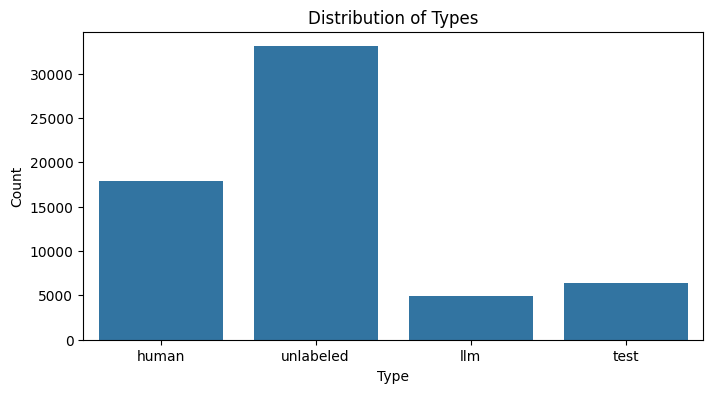

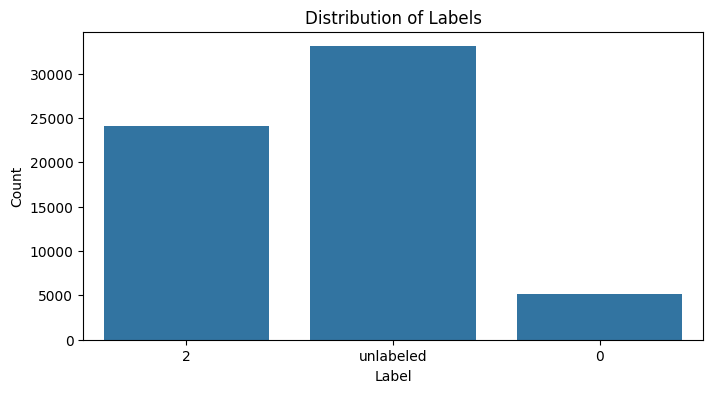

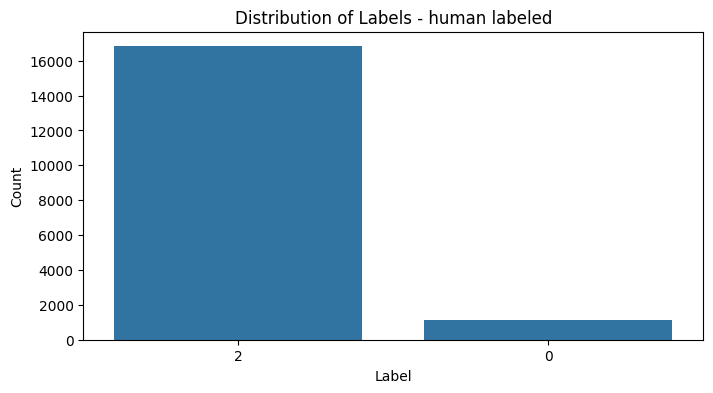

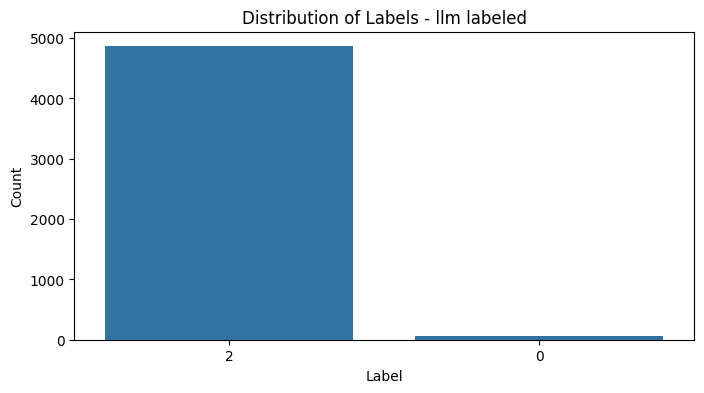

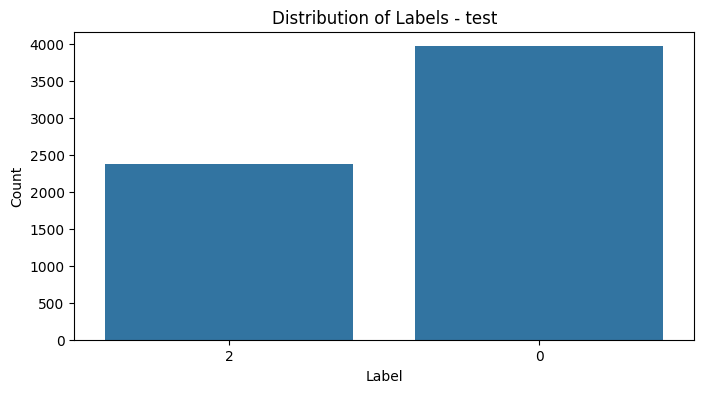


First few rows of the dataset:
                                                text       type      label
0  "QT @user In the original draft of the 7th boo...      human          2
4  @user Alciato: Bee will invest 150 million in ...      human          2
5  @user LIT MY MUM 'Kerry the louboutins I wonde...      human          2
6  "\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIA...      human          2
7  So disappointed in wwe summerslam! I want to s...  unlabeled  unlabeled


In [43]:
# Print value counts for each type and label combination
print("LLM labeled value counts:")
print(final_dataset_with_generated_labels[final_dataset_with_generated_labels["type"] == "llm"]["label"].value_counts())
print("\nHuman labeled value counts:")
print(final_dataset_with_generated_labels[final_dataset_with_generated_labels["type"] == "human"]["label"].value_counts())
print("\nUnlabeled value counts:")
print(final_dataset_with_generated_labels[final_dataset_with_generated_labels["type"] == "unlabeled"]["label"].value_counts())

# Describe the dataset
print("\nDataset description:")
print(final_dataset_with_generated_labels.describe())


# Plot the distribution of types
plt.figure(figsize=(8, 4))
sns.countplot(data=final_dataset_with_generated_labels, x="type")
plt.title("Distribution of Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

# Plot the distribution of labels
plt.figure(figsize=(8, 4))
sns.countplot(data=final_dataset_with_generated_labels, x="label")
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Plot the distribution of labels - human
plt.figure(figsize=(8, 4))
sns.countplot(data=final_dataset_with_generated_labels[final_dataset_with_generated_labels["type"]=="human"], x="label")
plt.title("Distribution of Labels - human labeled")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Plot the distribution of labels - llm
plt.figure(figsize=(8, 4))
sns.countplot(data=final_dataset_with_generated_labels[final_dataset_with_generated_labels["type"]=="llm"], x="label")
plt.title("Distribution of Labels - llm labeled")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Plot the distribution of labels - test
plt.figure(figsize=(8, 4))
sns.countplot(data=final_dataset_with_generated_labels[final_dataset_with_generated_labels["type"]=="test"], x="label")
plt.title("Distribution of Labels - test")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(final_dataset_with_generated_labels.head())

In [44]:
final_dataset_with_generated_labels.to_csv("../modified_datasets/final_dataset.csv")

In [45]:
final_dataset_with_generated_labels

,text,type,label
0,"""QT @user In the original draft of the 7th boo...",human,2
4,@user Alciato: Bee will invest 150 million in ...,human,2
5,@user LIT MY MUM 'Kerry the louboutins I wonde...,human,2
6,"""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...",human,2
7,So disappointed in wwe summerslam! I want to s...,unlabeled,unlabeled
...,...,...,...
59888,@user for al the crying you do about how middl...,test,0
59892,"i'm not even catholic, but pope francis is my ...",test,2
59893,@user @user @user Looks like Flynn isn't too p...,test,0
59897,Trying to have a conversation with my dad abou...,test,0
